In [5]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import lfilter
from scipy.signal import TransferFunction, freqz, iirfilter, periodogram
from scipy import signal

# 1 - get the filter coefficients and get a database

### Coeficientes do filtro

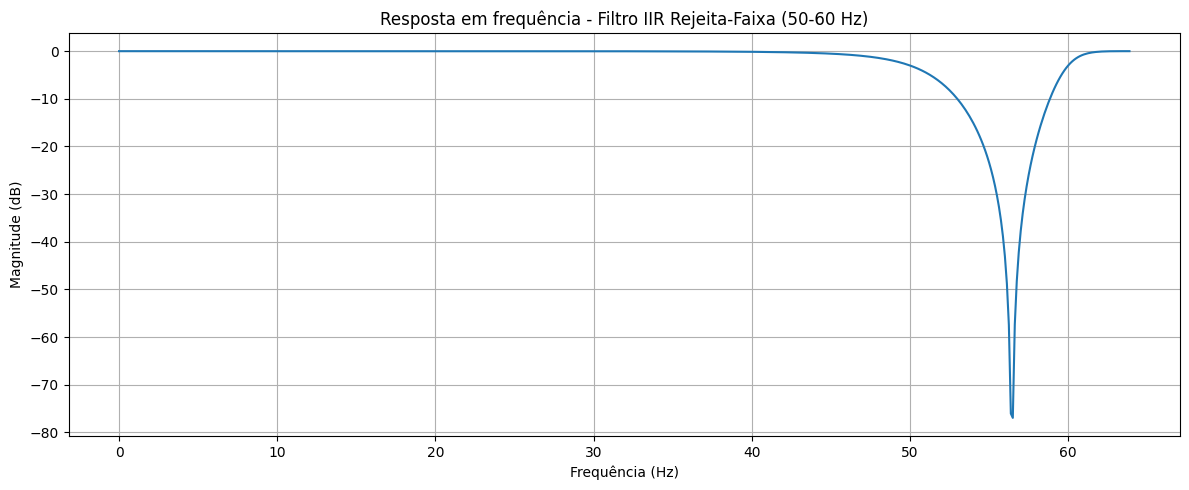

[ 64.         198.18608251 241.56719386 138.54408842  32.0003963 ]
[ 45.16629679 168.36508546 247.23499657 168.36508546  45.16629679]


In [8]:
# Parâmetros
fs = 128
order = 2

# Frequências em Hz
low = 50
high = 60

# Obter os pesos do filtro
b, a = iirfilter(order, [low, high], btype='bandstop', ftype='butter', fs=fs)

# Diagrama de Bode
w, h = freqz(b, a, fs=fs)
plt.figure(figsize=(12, 5))
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Resposta em frequência - Filtro IIR Rejeita-Faixa (50-60 Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()

a_q6 = a * (2**6)
b_q6 = b * (2**6)

print(a_q6)
print(b_q6)

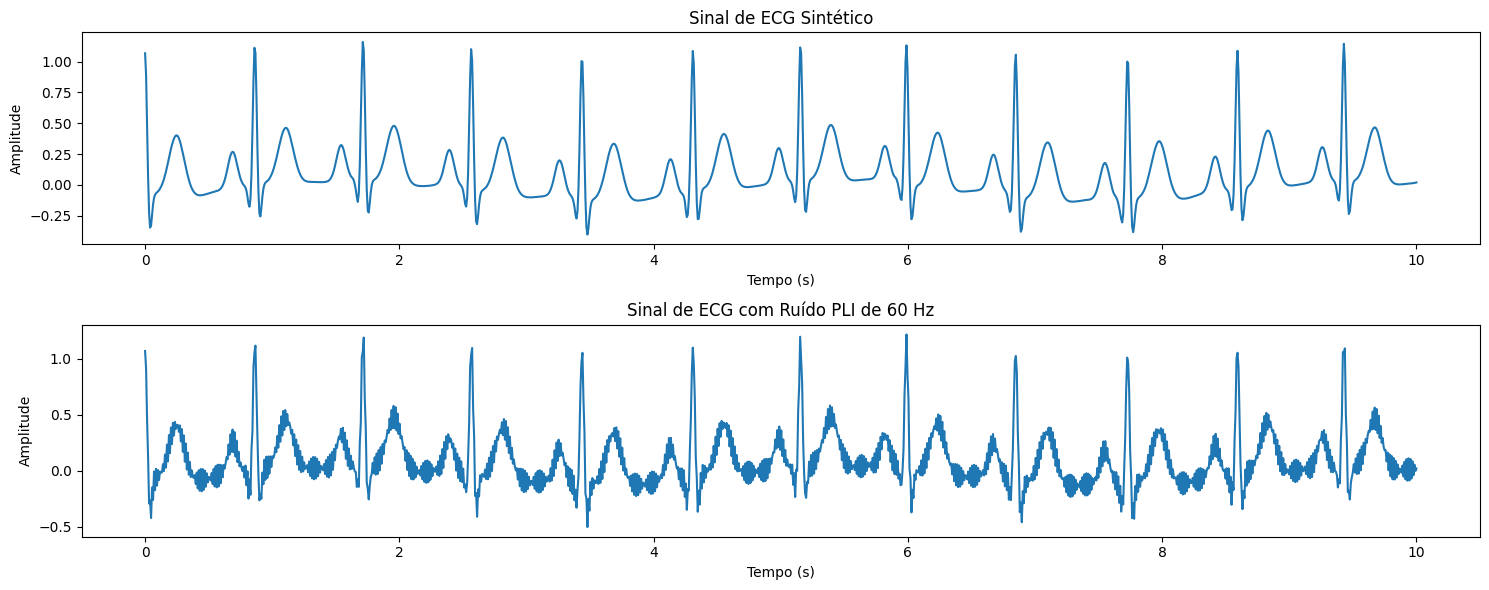

In [6]:
# Gerar um sinal de ECG sintético
sampling_rate = 128  # Taxa de amostragem em Hz
duration = 10  # Duração em segundos
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate)

# Gerar ruído de interferência de linha de energia (PLI) de 60 Hz
t = np.linspace(0, duration, int(sampling_rate * duration))
pli_noise = 0.1 * np.sin(2 * np.pi * 60 * t)  # Amplitude do ruído definida como 0.1

# Adicionar o ruído ao sinal de ECG
ecg_with_noise = ecg_signal + pli_noise

# Plotar o sinal de ECG original e o sinal com ruído
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(t, ecg_signal)
plt.title("Sinal de ECG Sintético")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t, ecg_with_noise)
plt.title("Sinal de ECG com Ruído PLI de 60 Hz")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [7]:
# Salvando o arquivo em ponto fixo
ecg_aux = np.zeros(len(ecg_with_noise))
for i in range(len(ecg_with_noise)):
    ecg_aux[i] = np.trunc(ecg_with_noise[i]*(2**6))
    
np.savetxt('signal_art.txt', ecg_aux, fmt='%d')

# 2 - Make a fixed-point reference model

In [10]:
# Parâmetros do sinal
fs = 128  # Frequência de amostragem (Hz)
T = 5      # Duração do sinal (s)
t = np.linspace(0, T, int(T * fs), endpoint=False)  # Vetor de tempo

# Senoide com variação de frequência: chirp linear
f0 = 1         # Hz
f1 = 100       # Hz
k = (f1 - f0) / T
x = np.sin(2 * np.pi * (f0 * t + 0.5 * k * t**2))

# Aplicar o filtro IIR manualmente
y = np.zeros_like(x)
for n in range(len(x)):
    # Parte do numerador
    for i in range(len(b)):
        if n - i >= 0:
            y[n] += b[i] * x[n - i]
    # Parte do denominador (ignorando a[0] = 1)
    for j in range(1, len(a)):
        if n - j >= 0:
            y[n] -= a[j] * y[n - j]

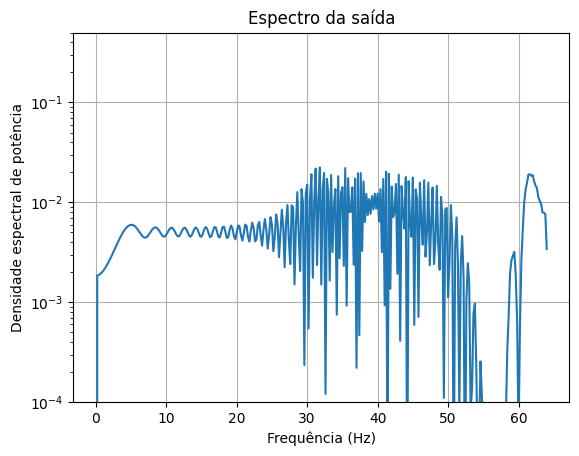

In [21]:
# Estimar a densidade espectral de potência
f, Pxx = periodogram(y, fs=fs)

# Plot
plt.semilogy(f, Pxx)
plt.title('Espectro da saída')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade espectral de potência')
plt.ylim(10e-5, 0.5)
plt.grid()
plt.show()

# 3 - Simulate and obtain RTL results

# 4 - Compare values

# 5 - make synthesis